# 기업 성공 확률 구하기
Ref.https://dacon.io/competitions/official/236475/data

데이터 수집하기         o
데이터 탐색 및 전처리   
특성 공학
모델 선택


In [60]:
import pandas as pd
import matplotlib.pyplot as plt
#한글 폰트 설정
import matplotlib.font_manager as fm
import platform
import seaborn as sns
from matplotlib import rc
from scipy.stats import zscore
if platform.system() == 'Windows':
    font_path = 'C:/Windows/Fonts/malgun.ttf'  # 맑은 고딕 폰트 경로
    font_name = fm.FontProperties(fname=font_path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':  # macOS
    rc('font', family='AppleGothic')
else:  # Linux
    rc('font', family='NanumGothic')

# 데이터 확인 하기
#files_in_parent = os.listdir(parent_dir) 
file_path = 'C:/Users/302/Documents/미래융합교육원/MLdata/probability_of_company_success/train.csv'

df = pd.read_csv(file_path)
print(df.head())
print(df.tail())

           ID  설립연도     국가    분야      투자단계    직원 수 인수여부 상장여부  고객수(백만명)  \
0  TRAIN_0000  2009  CT005  이커머스  Series A  4126.0   No   No      56.0   
1  TRAIN_0001  2023  CT006   핀테크      Seed  4167.0  Yes   No      80.0   
2  TRAIN_0002  2018  CT007    기술  Series A  3132.0  Yes  Yes      54.0   
3  TRAIN_0003  2016  CT006   NaN      Seed  3245.0  Yes  Yes       NaN   
4  TRAIN_0004  2020  CT002  에듀테크      Seed  1969.0   No  Yes      94.0   

   총 투자금(억원)  연매출(억원)  SNS 팔로워 수(백만명)  기업가치(백억원)  성공확률  
0     3365.0   4764.0            4.71        NaN   0.3  
1     4069.0    279.0            1.00  2500-3500   0.8  
2     6453.0  12141.0            4.00  3500-4500   0.5  
3      665.0  10547.0            2.97        NaN   0.7  
4      829.0   9810.0            1.00  1500-2500   0.1  
              ID  설립연도     국가    분야      투자단계    직원 수 인수여부 상장여부  고객수(백만명)  \
4371  TRAIN_4371  2021  CT006  푸드테크  Series A  4841.0  Yes   No      90.0   
4372  TRAIN_4372  2020  CT003   에너지  Series B   555.0   No 

In [48]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4376 entries, 0 to 4375
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              4376 non-null   object 
 1   설립연도            4376 non-null   int64  
 2   국가              4376 non-null   object 
 3   분야              3519 non-null   object 
 4   투자단계            4376 non-null   object 
 5   직원 수            4202 non-null   float64
 6   인수여부            4376 non-null   object 
 7   상장여부            4376 non-null   object 
 8   고객수(백만명)        3056 non-null   float64
 9   총 투자금(억원)       4376 non-null   float64
 10  연매출(억원)         4376 non-null   float64
 11  SNS 팔로워 수(백만명)  4376 non-null   float64
 12  기업가치(백억원)       3156 non-null   object 
 13  성공확률            4376 non-null   float64
dtypes: float64(6), int64(1), object(7)
memory usage: 478.8+ KB
None


In [49]:
# 결측치 확인
print(df.isnull().sum())
# 결측치 비율 확인
print(df.isnull().sum() / len(df) * 100)
# 결측치 비율 시각화


ID                   0
설립연도                 0
국가                   0
분야                 857
투자단계                 0
직원 수               174
인수여부                 0
상장여부                 0
고객수(백만명)          1320
총 투자금(억원)            0
연매출(억원)              0
SNS 팔로워 수(백만명)       0
기업가치(백억원)         1220
성공확률                 0
dtype: int64
ID                 0.000000
설립연도               0.000000
국가                 0.000000
분야                19.584095
투자단계               0.000000
직원 수               3.976234
인수여부               0.000000
상장여부               0.000000
고객수(백만명)          30.164534
총 투자금(억원)          0.000000
연매출(억원)            0.000000
SNS 팔로워 수(백만명)     0.000000
기업가치(백억원)         27.879342
성공확률               0.000000
dtype: float64


<Axes: >

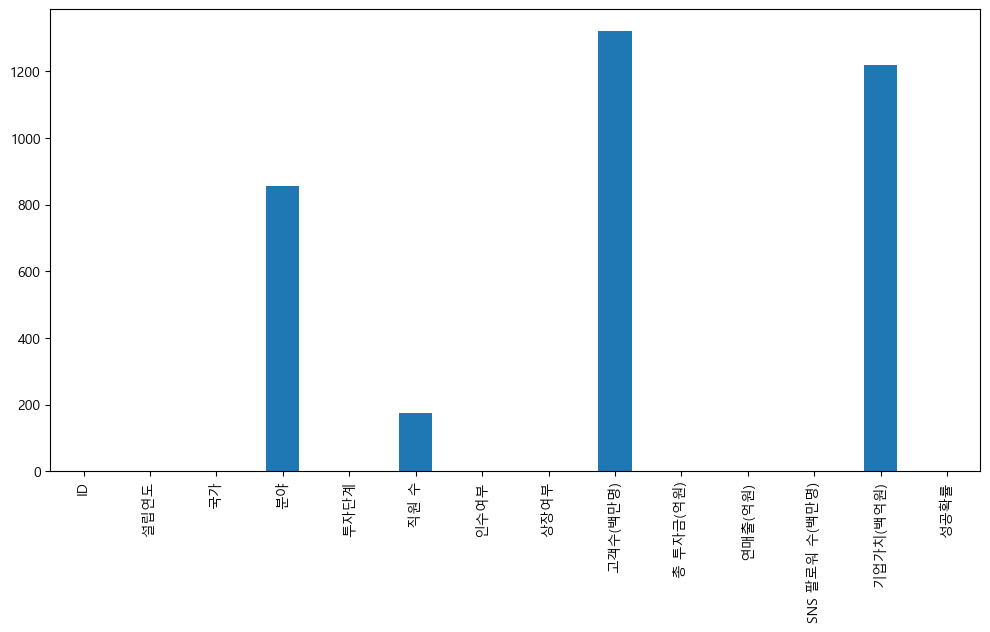

In [50]:
plt.figure(figsize=(12, 6))
df.isnull().sum().plot(kind='bar')

In [51]:
print(df.shape)

(4376, 14)


피쳐 간 상관계수 (연매출과 직원수의 상관관계 확인)

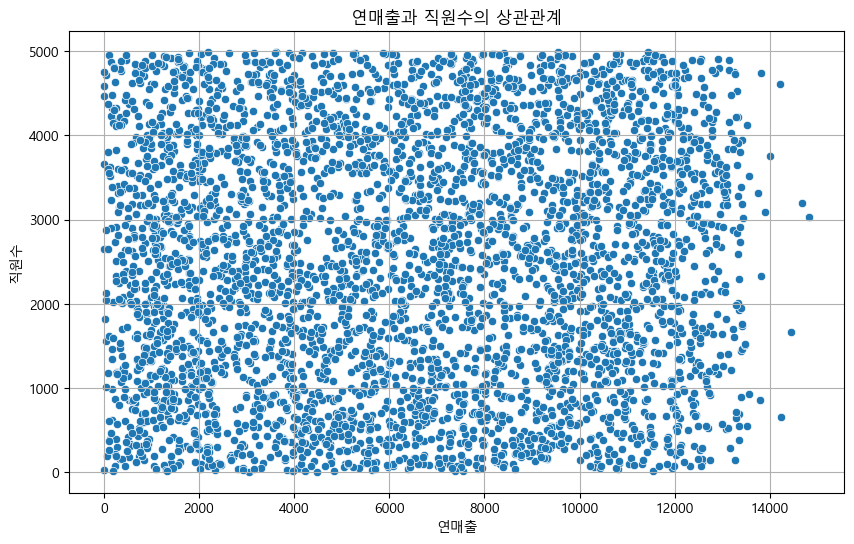

In [52]:
# 연매출과 직원수의 상관관계 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='연매출(억원)', y='직원 수')
plt.title('연매출과 직원수의 상관관계')
plt.xlabel('연매출')
plt.ylabel('직원수')
plt.grid(True)
plt.show()

In [53]:
from sklearn.linear_model import LinearRegression
import numpy as np

# 데이터프레임 복사
df_copy = df.copy()

# 결측치 처리 (결측치를 평균값으로 대체)
df_copy['연매출(억원)'] = df_copy['연매출(억원)'].fillna(df_copy['연매출(억원)'].mean())
df_copy['직원 수'] = df_copy['직원 수'].fillna(df_copy['직원 수'].mean())

# 데이터 준비
X = df_copy['연매출(억원)'].values.reshape(-1, 1)  # X는 2D 배열이어야 함
y = df_copy['직원 수'].values

# 선형 회귀 모델 학습
model = LinearRegression()
model.fit(X, y)

# R² 값 출력
r_squared = model.score(X, y)
print(f"R² 값: {r_squared:.2f}")

R² 값: 0.00


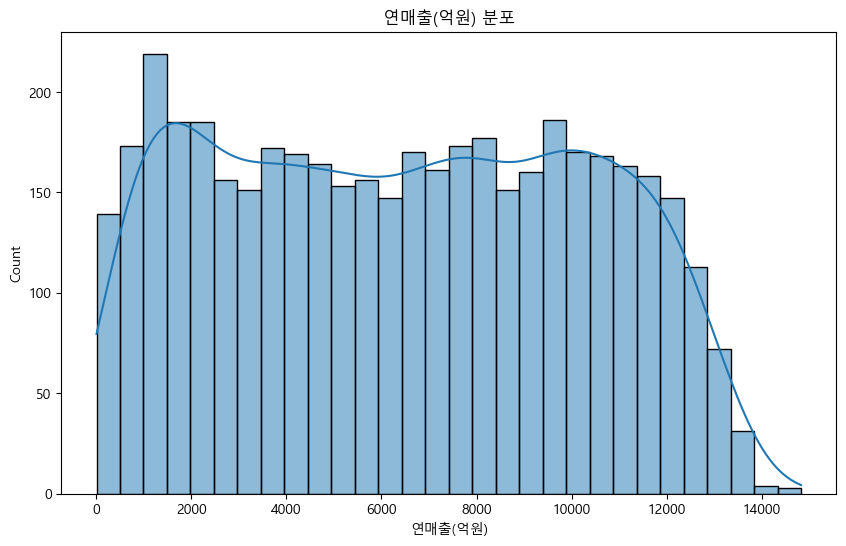

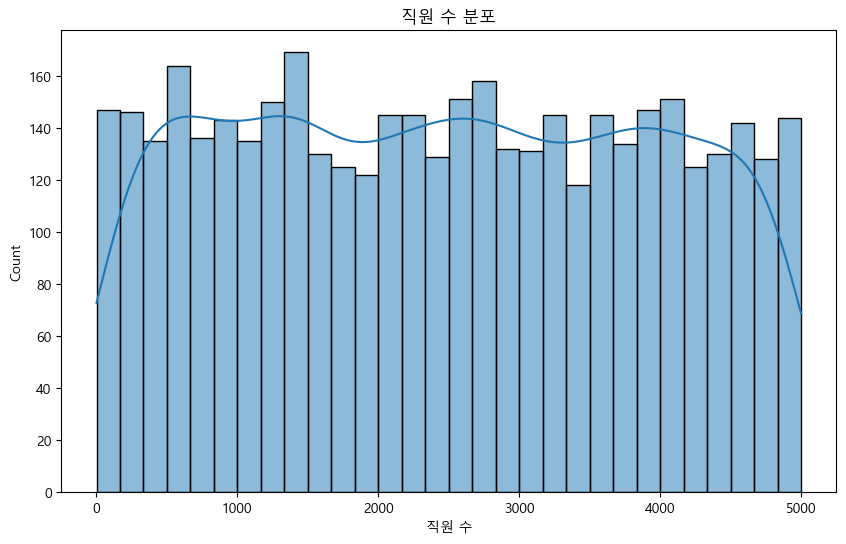

In [54]:
# 연매출(억원) 분포 확인
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='연매출(억원)', kde=True, bins=30)
plt.title('연매출(억원) 분포')
plt.show()

# 직원 수 분포 확인
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='직원 수', kde=True, bins=30)
plt.title('직원 수 분포')
plt.show()


회사 분야와 직원수의 상관관계

내가 생각하기엔 

['이커머스' '핀테크' '기술' nan '에듀테크' '게임' '헬스케어' '물류' '푸드테크' 'AI' '에너지']
분야
에너지     396
기술      389
에듀테크    364
게임      359
AI      356
핀테크     344
푸드테크    335
이커머스    332
물류      328
헬스케어    316
Name: count, dtype: int64


C:\Users\302\AppData\Local\Temp\ipykernel_4192\926620223.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_employees_by_field, x='직원 수', y='분야', palette='viridis')


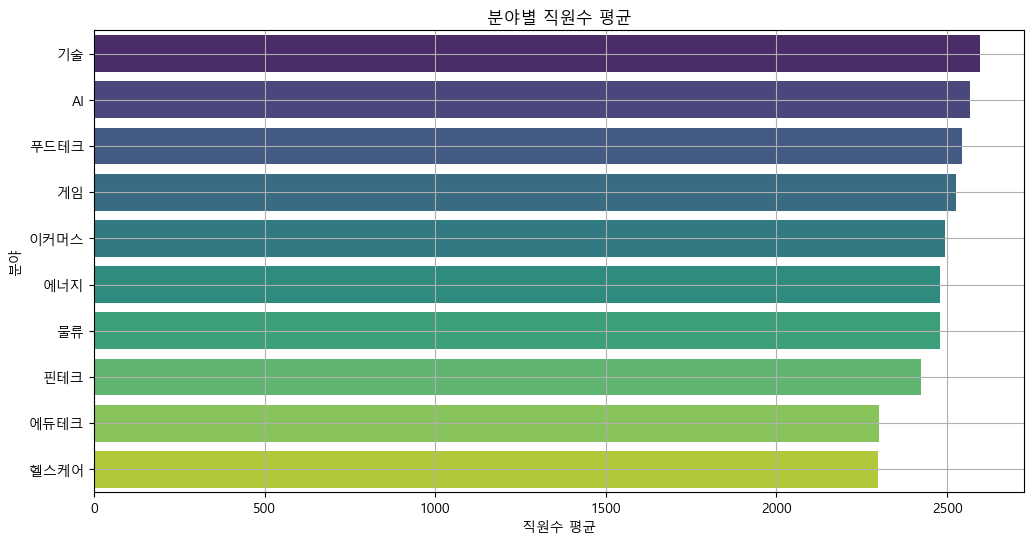

In [55]:
# 분야 별 직원수 시각화
# 회사 분야의 고유값 확인
print(df['분야'].unique())
print(df['분야'].value_counts())

# 각 분야별 직원수 평균 계산
mean_employees_by_field = df.groupby('분야')['직원 수'].mean().reset_index()
mean_employees_by_field = mean_employees_by_field.sort_values(by='직원 수', ascending=False)

# 분야별 직원수 평균 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=mean_employees_by_field, x='직원 수', y='분야', palette='viridis')
plt.title('분야별 직원수 평균')
plt.xlabel('직원수 평균')
plt.ylabel('분야')

plt.grid(True)
plt.show()

C:\Users\302\AppData\Local\Temp\ipykernel_4192\1200576363.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_revenue_by_field, x='연매출(억원)', y='분야', palette='viridis')


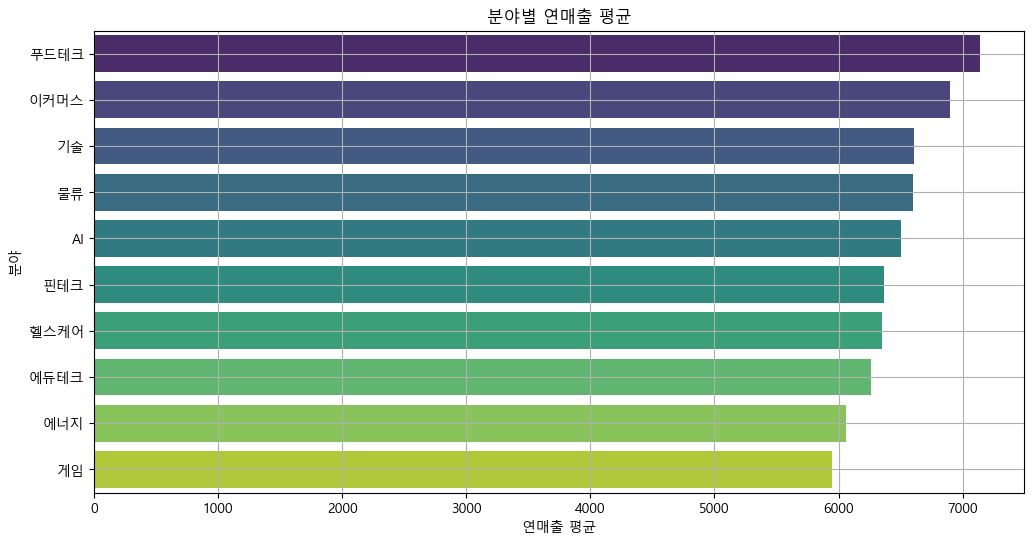

In [56]:
# 분야별 연매출 시각화
mean_revenue_by_field = df.groupby('분야')['연매출(억원)'].mean().reset_index()
mean_revenue_by_field = mean_revenue_by_field.sort_values(by='연매출(억원)', ascending=False)

# 분야별 연매출 평균 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=mean_revenue_by_field, x='연매출(억원)', y='분야', palette='viridis')
plt.title('분야별 연매출 평균')
plt.xlabel('연매출 평균')
plt.ylabel('분야')
plt.grid(True)
plt.show()




In [57]:
# 데이터 요약
print(df.describe())  # 수치형 데이터의 기본 통계
print(df.info())  # 데이터 타입 및 결측치 확인

              설립연도         직원 수     고객수(백만명)    총 투자금(억원)       연매출(억원)  \
count  4376.000000  4202.000000  3056.000000  4376.000000   4376.000000   
mean   2012.006856  2471.324369    49.214332  3314.568556   6452.202239   
std       6.554872  1446.064215    27.141242  1880.103831   3782.792656   
min    2001.000000     5.000000     1.000000    12.000000     12.000000   
25%    2006.000000  1218.250000    27.000000  1651.500000   3094.250000   
50%    2012.000000  2472.000000    49.000000  3398.000000   6478.500000   
75%    2018.000000  3727.500000    72.000000  4908.250000   9692.500000   
max    2023.000000  4998.000000    99.000000  7059.000000  14822.000000   

       SNS 팔로워 수(백만명)         성공확률  
count     4376.000000  4376.000000  
mean         2.578103     0.537340  
std          1.414590     0.241698  
min          0.000000     0.100000  
25%          1.320000     0.400000  
50%          2.835000     0.600000  
75%          4.000000     0.700000  
max          5.000000     0.

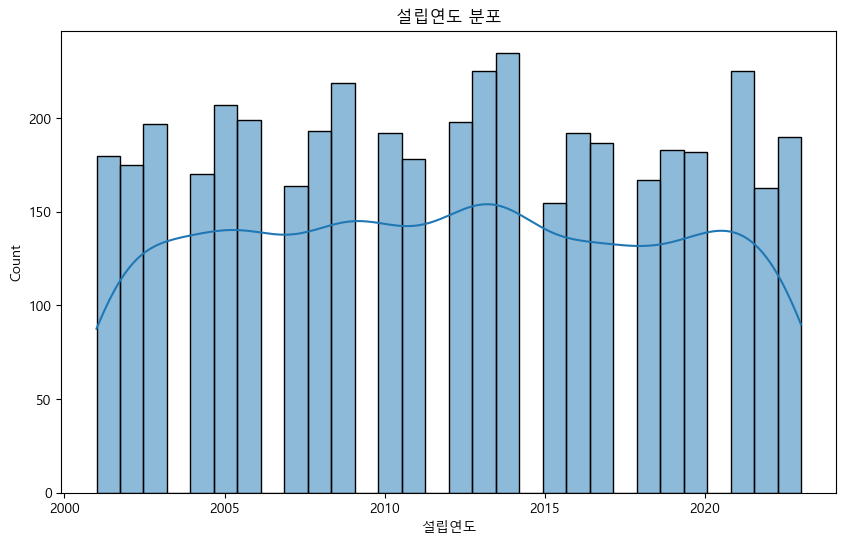

In [58]:
# 직원 수 분포 확인
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='설립연도', kde=True, bins=30)
plt.title('설립연도 분포')
plt.show()

In [63]:
# 모든 수치형 피처에 대해 Z-스코어 계산
z_scores = df.select_dtypes(include=['number']).apply(zscore)

# Z-스코어가 ±3을 초과하는 이상치 탐지
outliers = (z_scores.abs() > 2)

# 이상치 개수 확인
outliers_count = outliers.sum()
print("각 피처별 Z-스코어 ±3 초과 이상치 개수:")
print(outliers_count)

# 이상치가 있는 행 확인
outliers_rows = df[outliers.any(axis=1)]
print("\n이상치가 포함된 행:")
print(outliers_rows)

각 피처별 Z-스코어 ±3 초과 이상치 개수:
설립연도              0
직원 수              0
고객수(백만명)          0
총 투자금(억원)         0
연매출(억원)           5
SNS 팔로워 수(백만명)    0
성공확률              0
연매출_Z             5
직원수_Z             0
dtype: int64

이상치가 포함된 행:
              ID  설립연도     국가    분야      투자단계    직원 수 인수여부 상장여부  고객수(백만명)  \
1016  TRAIN_1016  2006  CT005  이커머스  Series A  4617.0   No  Yes       NaN   
2049  TRAIN_2049  2020  CT005  헬스케어      Seed  3026.0   No   No       NaN   
2623  TRAIN_2623  2017  CT004    물류  Series B  1658.0   No  Yes      97.0   
3154  TRAIN_3154  2003  CT008   NaN  Series C  3202.0  Yes   No       NaN   
4224  TRAIN_4224  2015  CT006    물류       IPO   650.0   No  Yes      57.0   

      총 투자금(억원)  연매출(억원)  SNS 팔로워 수(백만명)  기업가치(백억원)  성공확률     연매출_Z  직원수_Z  
1016       14.0  14210.0            2.74  1500-2500   0.6  2.051047    NaN  
2049     3426.0  14822.0            3.11  1500-2500   0.4  2.212850    NaN  
2623     6204.0  14451.0            4.00  1500-2500   0.1  2.114764    NaN